In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
import scipy
from perlin_noise import PerlinNoise
import cv2


COLOR = '#bbccd5'
BG = '#23272a'
# print(mpl.rcParams.keys()) # see all params
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
mpl.rcParams['figure.facecolor'] = BG
mpl.rcParams['figure.figsize'] = [16, 9]

## Helper Functions

In [2]:
def get_img(name, loc='imgs'):
    location = os.path.join(loc, name)
    img = plt.imread(location)
    if img.dtype == 'uint8':
        img = img.astype(np.float64) / 255
    return img

def scale_values(img):
    norm = (img - np.min(img)) 
    return norm / max(np.max(norm), 0.1)

def to_greyscale(img):
    if img.dtype == 'uint8':
        img = img / 256
    new_img = img[:,:,:3] # rgba -> rgb
    return np.repeat(np.mean(new_img, axis=2)[:, :, np.newaxis], 3, axis=2)

def side_by_side(img_a, img_b):
    size = 10
    ratio = img_a.shape[0] / img_a.shape[1]
    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(2 * size, size * ratio))
    
    axs[0].imshow(img_a)
    axs[1].imshow(img_b)
    
def clip(img, bounds=(0,1)):
    return np.clip(bounds[0], img, bounds[1])

## Some examples

Images are stored in imgs/examples number to match the image where a is for after and b is for before. So 1b and 1a are the same location before and after respectively.

source of example images: https://www.lemonde.fr/en/les-decodeurs/article/2022/07/22/before-and-after-satellite-images-of-the-massive-fires-in-gironde-france_5991052_8.html

In [3]:
def compare(before, after):
    diff = after - before # get the difference
    
    # I try to perform some filtering by removing non white colors (as smoke is mostly white/grey)
    ranges = diff.max(axis=2) - diff.min(axis=2)
    ranges = np.repeat(ranges[:,:,np.newaxis], 3, axis=2)
    diff = diff * (ranges < 0.1) * (to_greyscale(diff) > 0.1)
    
    diff = scale_values(diff) # scale the values to make it easier to see
    
    return diff
    
def plot_trio(l_small, r_small, center_large, labels =('Before' , 'After', 'Difference')):
    fig = plt.figure(figsize=(16,12))
    fig.tight_layout()
    
    plt.subplot(2, 1, 1)
    plt.title(labels[2])
    plt.imshow(center_large)

    plt.subplot(2, 2, 3)
    plt.title(labels[0])
    plt.imshow(l_small)

    plt.subplot(2, 2, 4)
    plt.title(labels[1])
    plt.imshow(r_small)

In [4]:
examples = []
for i in range(1, 1000):
    try:
        pair = []
        for version in 'ba':
            pair.append(get_img(os.path.join('examples', f'{i}{version}.jpg')))
        examples.append(pair)
    except FileNotFoundError:
        print(f'found {i - 1} images')
        break

found 4 images


In [5]:
for i, example in enumerate(examples):
    diff = compare(*example)
    examples[i].append(diff)

## Comparison Plots (you can colapse this section)

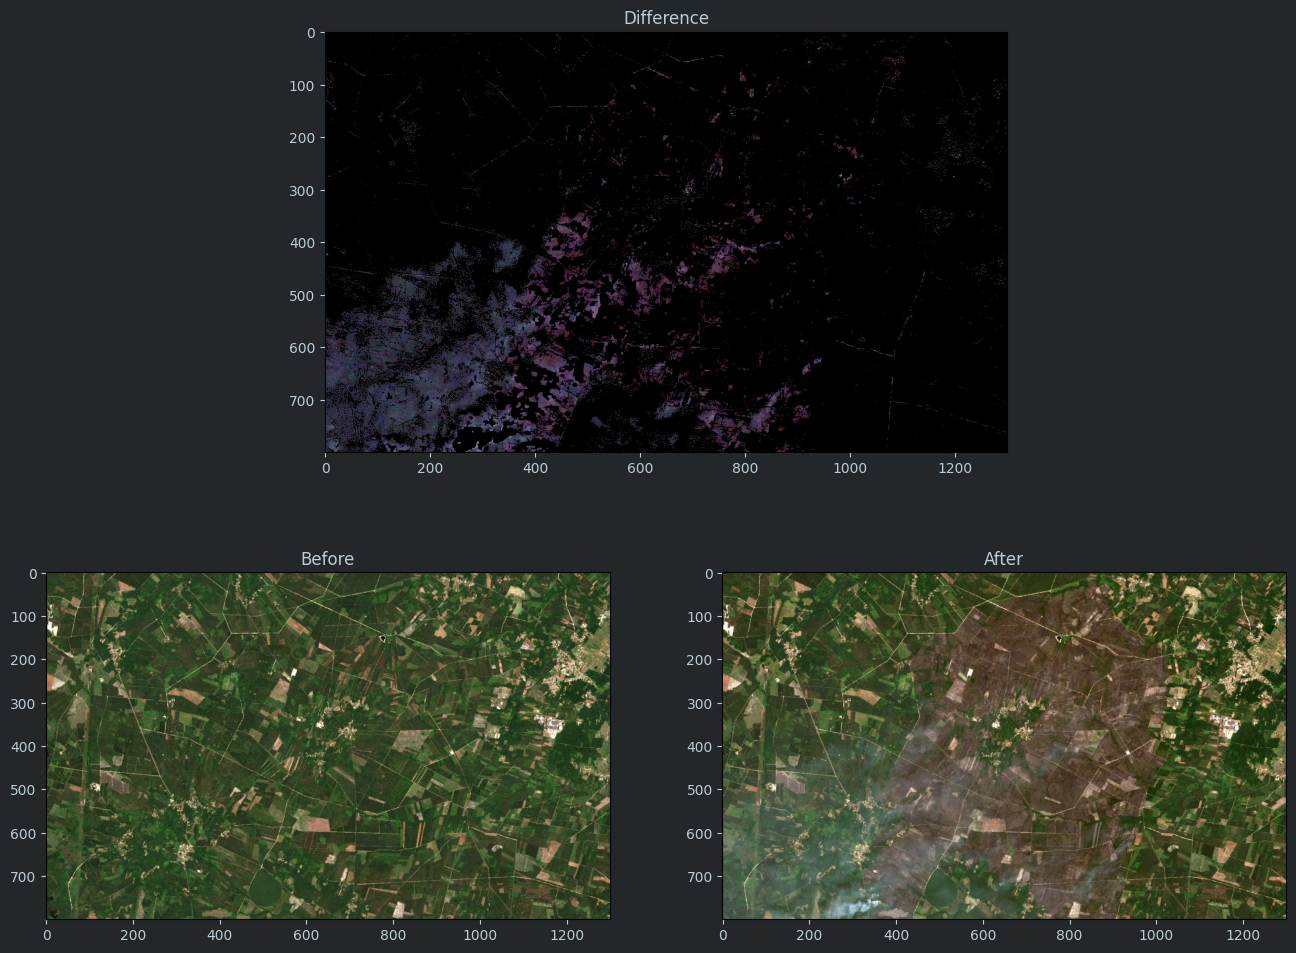

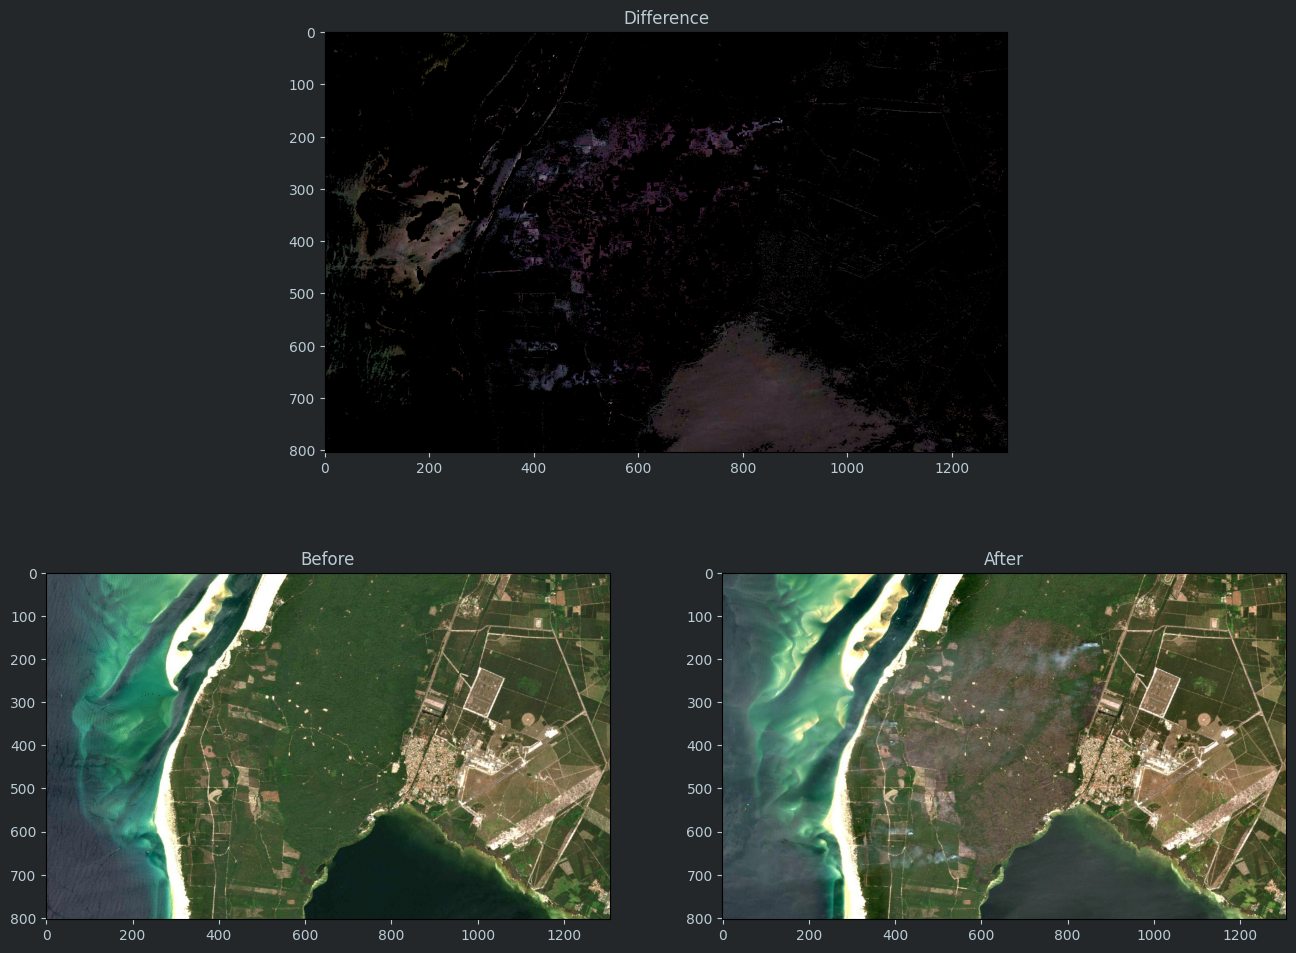

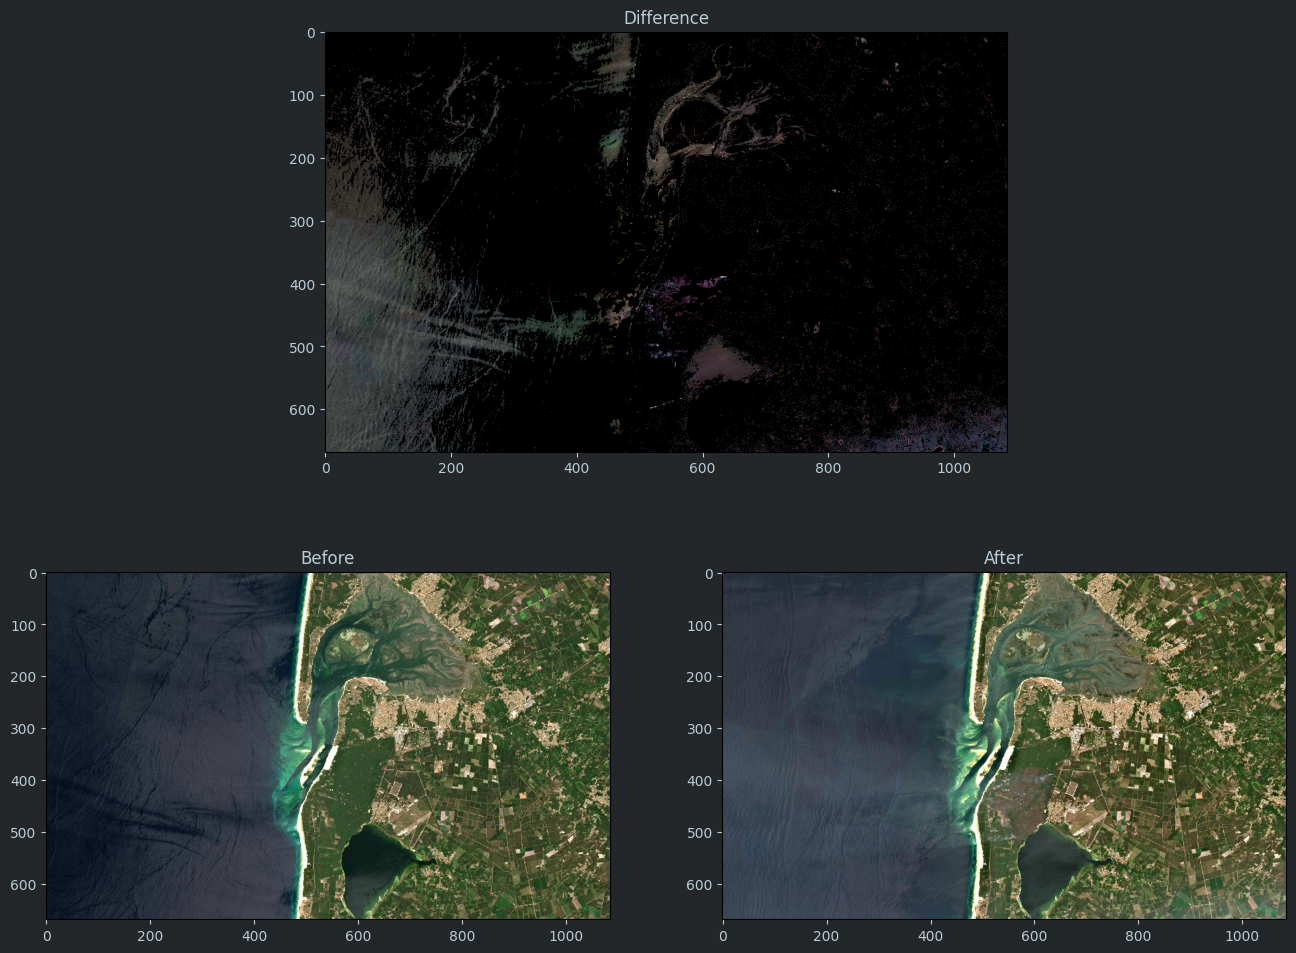

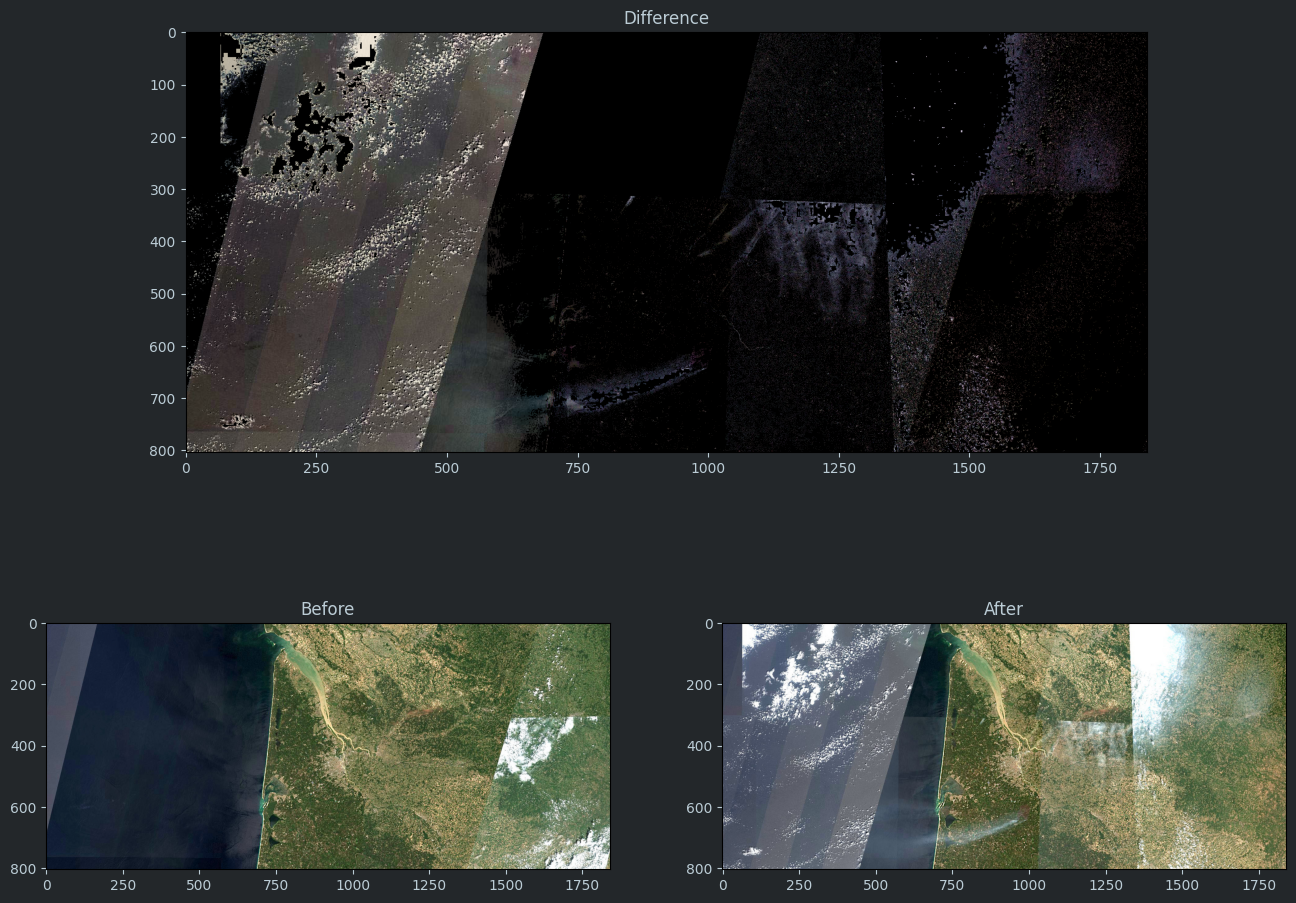

In [6]:
for example in examples:
    plot_trio(*example)

## Fire generation

Looking at this specific example I can identify 3 clear patterns of a fire.
1. We have a bright source
2. A dense smoke trail near the source
3. A more spread out smoke plume of smoke further out

From this we can consider some key parameters we would want to have for each:
1. For all
    1. Size
    2. Brightness
2. Source
    1. Shape (e.g. stretched oval and its orientation)
3. Smoke Trail
    1. Width in degrees as it spreads in a sector pattern see below ( or in other terms wind strength) 
    2. Wind direction
4. Other smoke
    1. I see it as potentially perlin noise and hence its relevant settings possibly translated to more meaningful smoke terms
    2. 1 and 2 from Smoke Trail

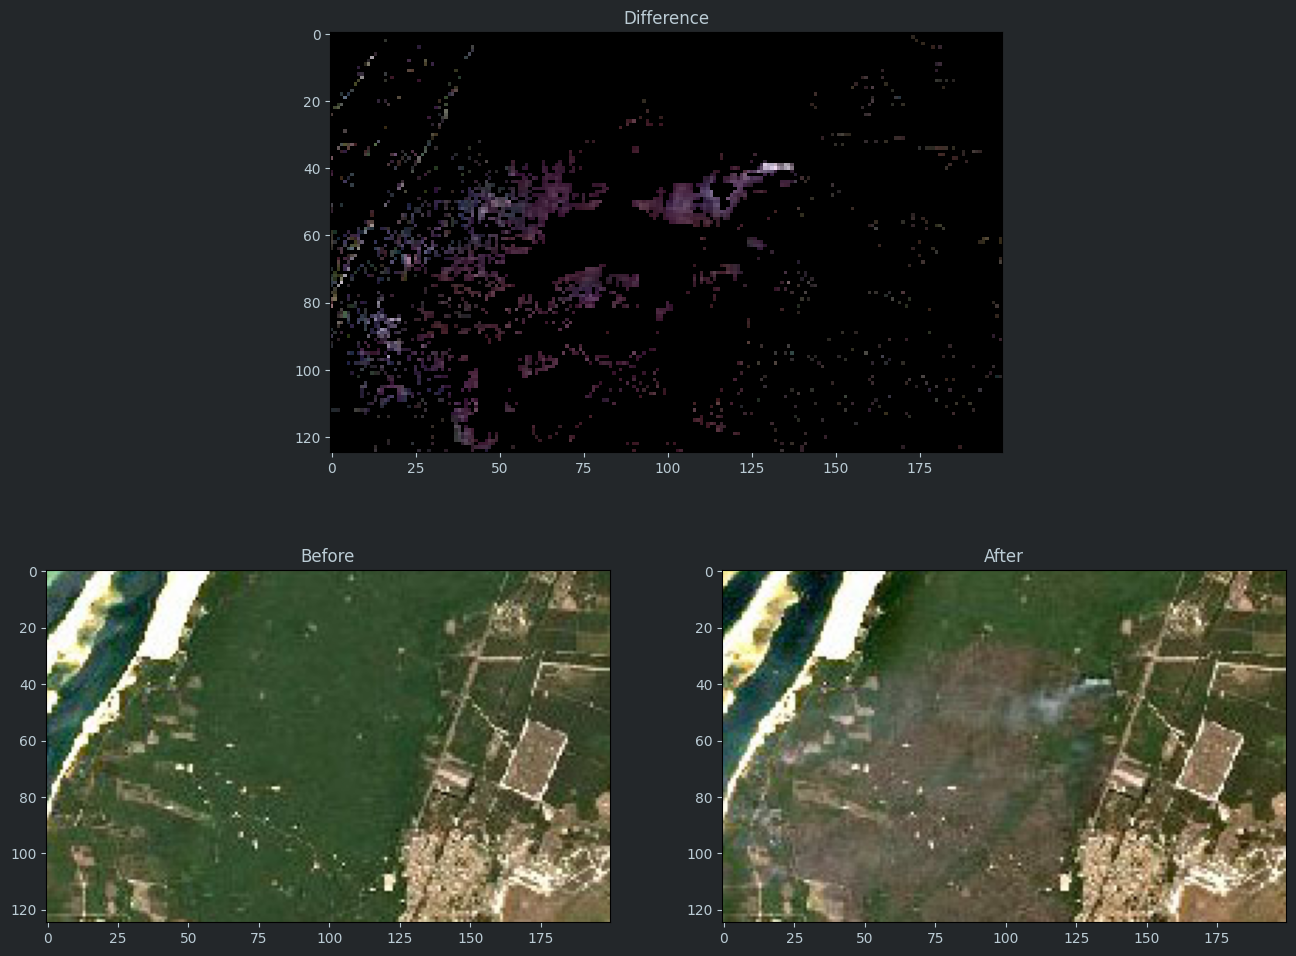

In [7]:
# looking at an example closer up
crop =[img[350:475, 500:700] for img in examples[2]]
plot_trio(*crop)

In [8]:
img = examples[2][0][350:475, 500:700]

In [9]:
def expand_to_rgb(img):
    return np.repeat(img[:,:,np.newaxis], 3, axis=2)

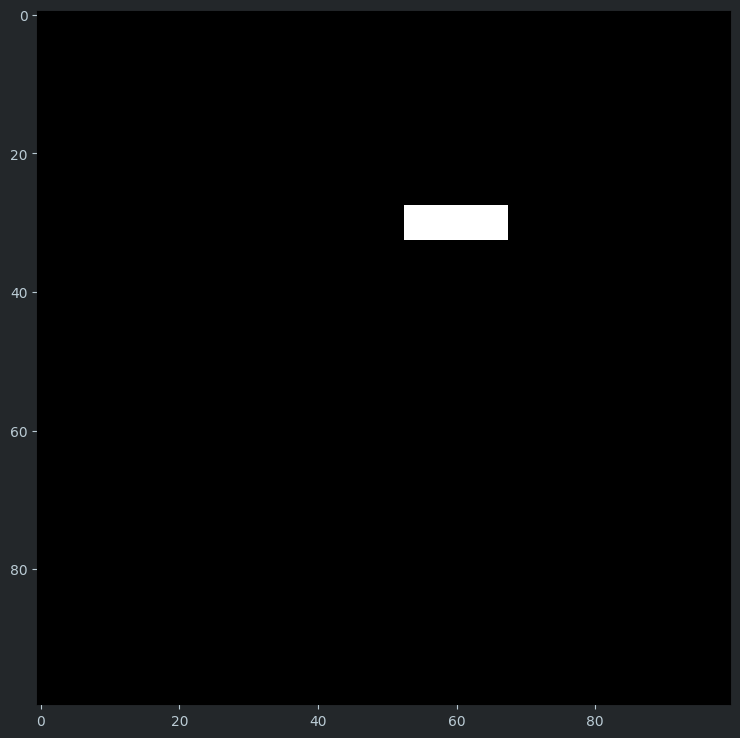

In [10]:
def create_centered_rectangle_mask(size, position, dims):
    circle_mask = np.zeros(size)
    for y in range(circle_mask.shape[0]):
        for x in range(circle_mask.shape[1]):
            if position[1] + dims[1] >= x >= position[1] - dims[1] and position[0] + dims[0] >= y >= position[0] - dims[0]:
                circle_mask[y, x] = 1
    return circle_mask

plt.imshow(create_centered_rectangle_mask((100, 100), (30, 60), (2, 7)), cmap= plt.cm.bone)

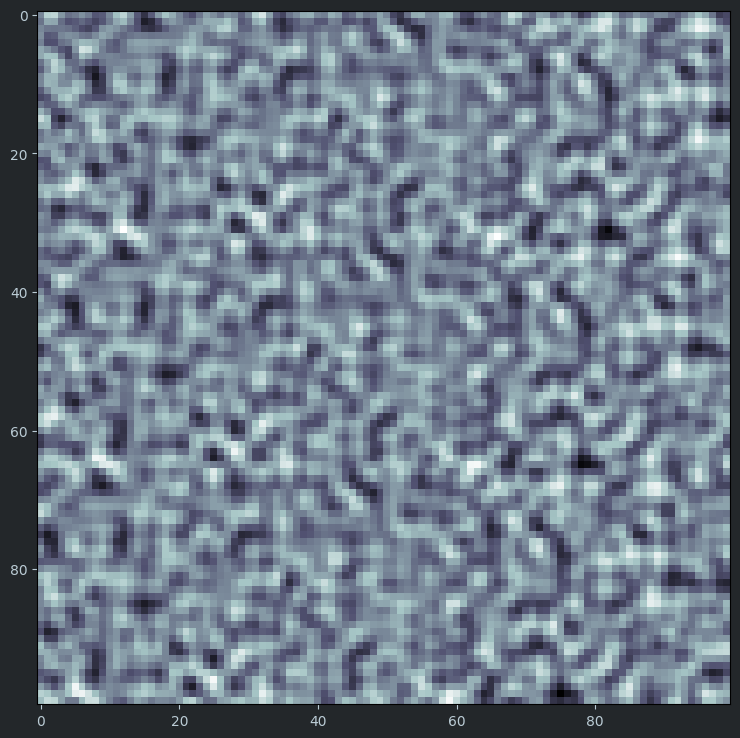

In [25]:
noise = PerlinNoise(octaves=30)
xpix, ypix = (100, 100)
smoke = scale_values(np.array([[noise([i/xpix, j/ypix]) for j in range(ypix)] for i in range(xpix)]))
plt.imshow(scale_values(smoke), cmap=plt.cm.bone)

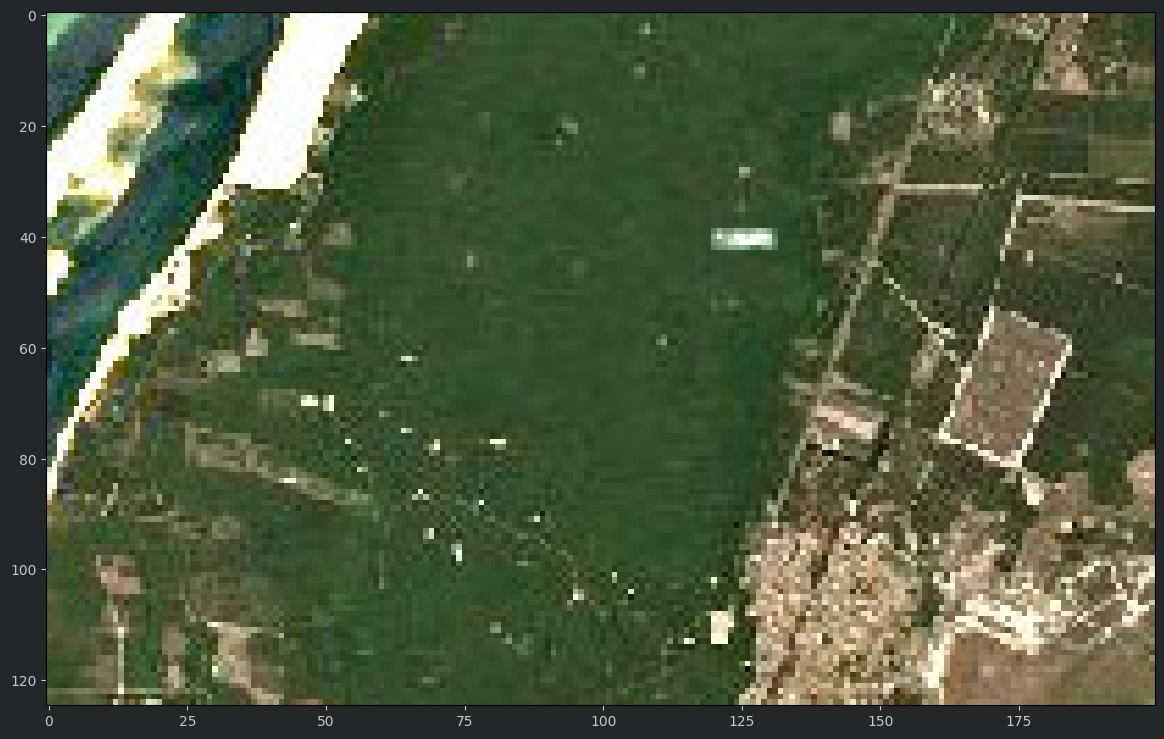

In [27]:
def insert(target, loc, tool): # there is a np.insert but i could not get it to work
    if len(tool.shape) == 2: # if missing color channel dimention
        tool = expand_to_rgb(tool)
        
    copy = target.copy()
    copy[loc[0]: loc[0] + tool.shape[0], loc[1]: loc[1] + tool.shape[1], :] = tool
    return copy

def generate_source(img, position, brightness, size, shape):
    noise = PerlinNoise(octaves=60)
    xpix, ypix = img.shape[:2]
    smoke = scale_values(np.array([[noise([i/xpix, j/ypix]) for j in range(ypix)] for i in range(xpix)]))
    
    
    
    mask = create_centered_rectangle_mask(img.shape[:2], position, (size * shape, size))
    # mask = cv2.GaussianBlur(mask, (11,11), cv2.BORDER_DEFAULT)
    blr_size = max(int(size * 0.3), 2)
    mask = cv2.blur(mask, (blr_size,blr_size))
    
    source = expand_to_rgb(smoke * mask) * brightness
    
    return source

source = generate_source(img, (40, 125), 1.5, 5, 2/7)
plt.imshow(clip(img + source))

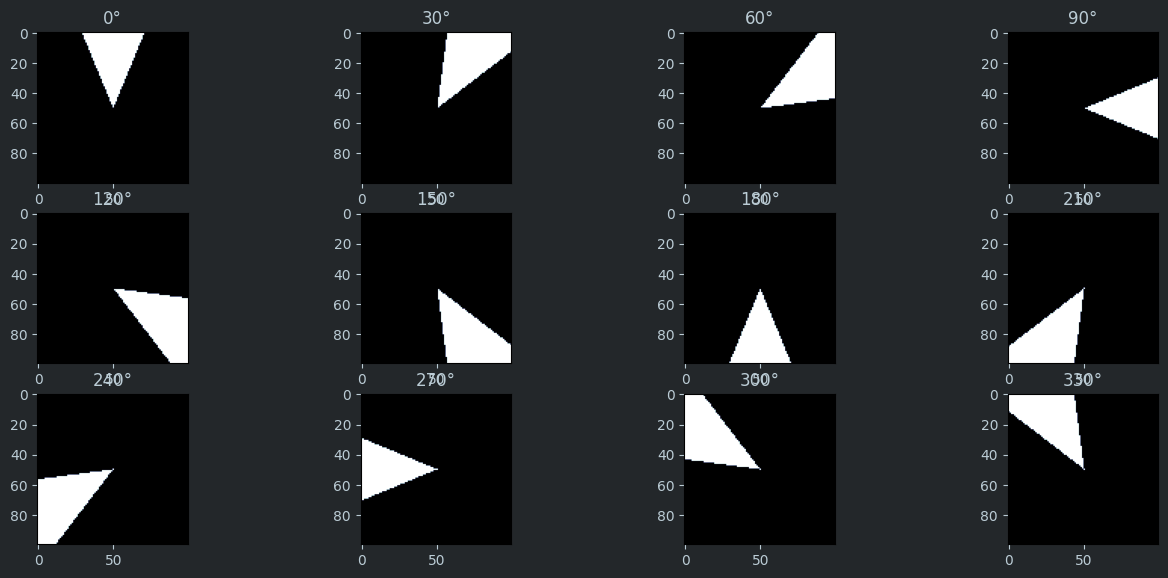

In [12]:

def create_cone_mask(size, position, width, direction):
    cone_mask = np.zeros(size)
    # create the two angles adding an offest for each edge of the cone as well as rotating to bearing coordinates i.e. 0deg is north
    angle1, angle2 = direction - width / 2 - np.pi / 2, direction + width / 2 - np.pi / 2
    # calcluate the gradient line given the angle
    gradient_boundary1, gradient_boundary2 = np.tan( angle1), np.tan(angle2)
    for y in range(cone_mask.shape[0]):
        for x in range(cone_mask.shape[1]):
            # get the side that the pixel is on for both lines
            divide1, divide2 = (y - position[0]) <= gradient_boundary1 * (x - position[1]), y - position[0] >= gradient_boundary2 * (x - position[1])
            # combine with threshold function that tells us if we want the space above or below the dividing line "sin(theta - pi/2) >= 0"
            if not( (divide1 != (np.sin(angle1 - np.pi / 2) >= 0)) or (divide2 != (np.sin(angle2 - np.pi / 2) >= 0))):
                cone_mask[y, x] = 1
    
    return cone_mask


fig = plt.figure()
items = 12
for i in range(items):
    direction = 2 * np.pi * i / items
    ax = fig.add_subplot(4, 4, i + 1, title=f'{np.rad2deg(direction):0.0f}°')
    ax.imshow(create_cone_mask((100, 100), (50, 50), np.deg2rad(45), direction), cmap=plt.cm.bone)

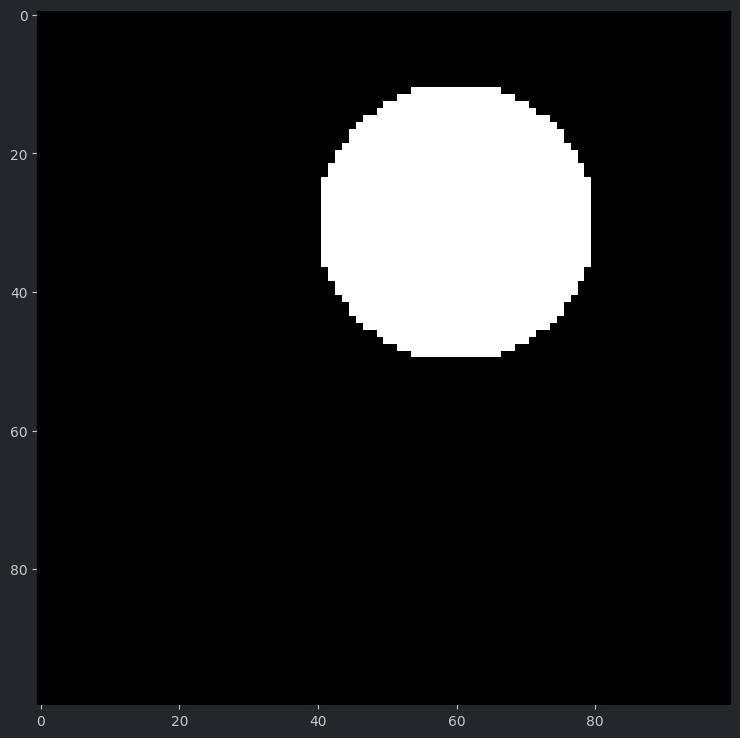

In [13]:
def create_circle_mask(size, position, radius):
    circle_mask = np.zeros(size)
    for y in range(circle_mask.shape[0]):
        for x in range(circle_mask.shape[1]):
            if radius ** 2 > (x - position[1]) ** 2 + (y - position[0]) ** 2:
                circle_mask[y, x] = 1
    return circle_mask

plt.imshow(create_circle_mask((100, 100), (30, 60), 20), cmap= plt.cm.bone)

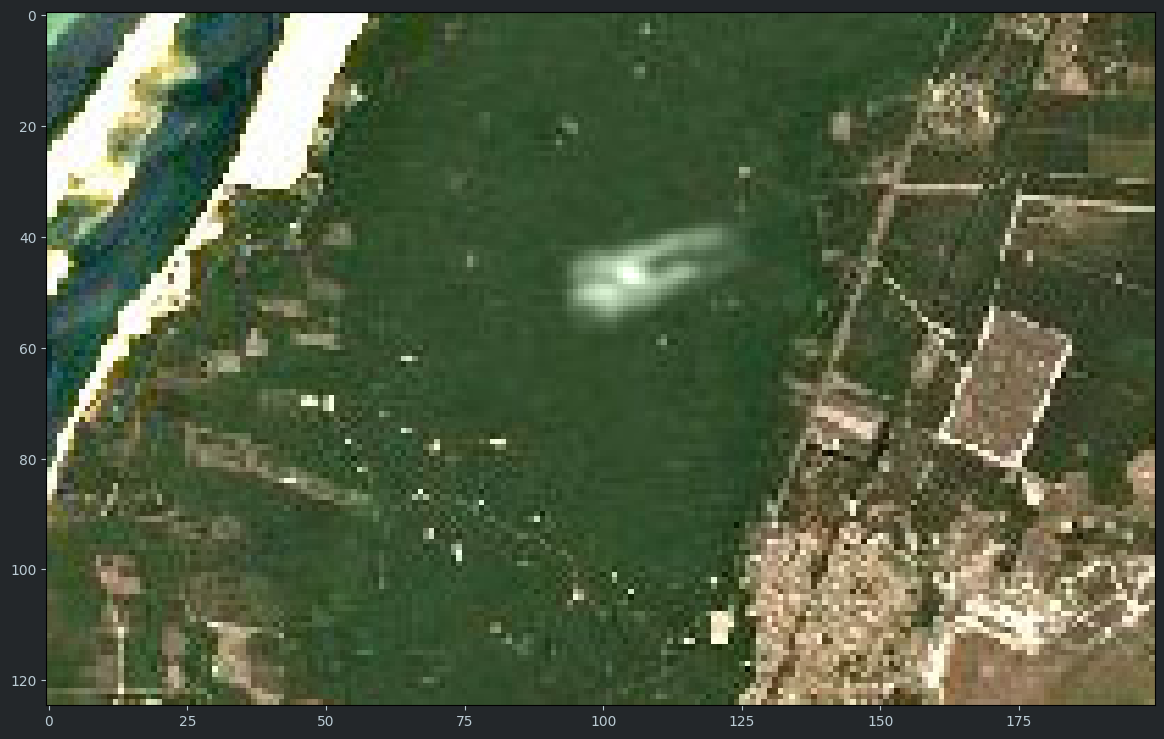

In [29]:
def generate_trail(img, position, brightness, width, direction, radius):
    trail = np.zeros_like(img)
    
    
    noise = PerlinNoise(octaves=30)
    xpix, ypix = img.shape[:2]
    smoke = scale_values(np.array([[noise([i/xpix, j/ypix]) for j in range(ypix)] for i in range(xpix)]))
    
    
    cone_mask = create_cone_mask(img.shape[:2], position, width, direction)
    circle_mask = create_circle_mask(img.shape[:2], position, radius)
    
    mask = cone_mask * circle_mask
    # mask = cv2.GaussianBlur(mask, (11,11), cv2.BORDER_DEFAULT)
    blr_size = int(radius * 0.3)
    mask = cv2.blur(mask, (blr_size,blr_size))
    
    trail = expand_to_rgb(smoke * mask) * brightness
    
    return trail

trail = generate_trail(img, (40, 125), 2, np.deg2rad(15), np.deg2rad(250), 30)
plt.imshow(clip(img + trail)) # TODO: Not sure why cliping in this case causes dark spots 

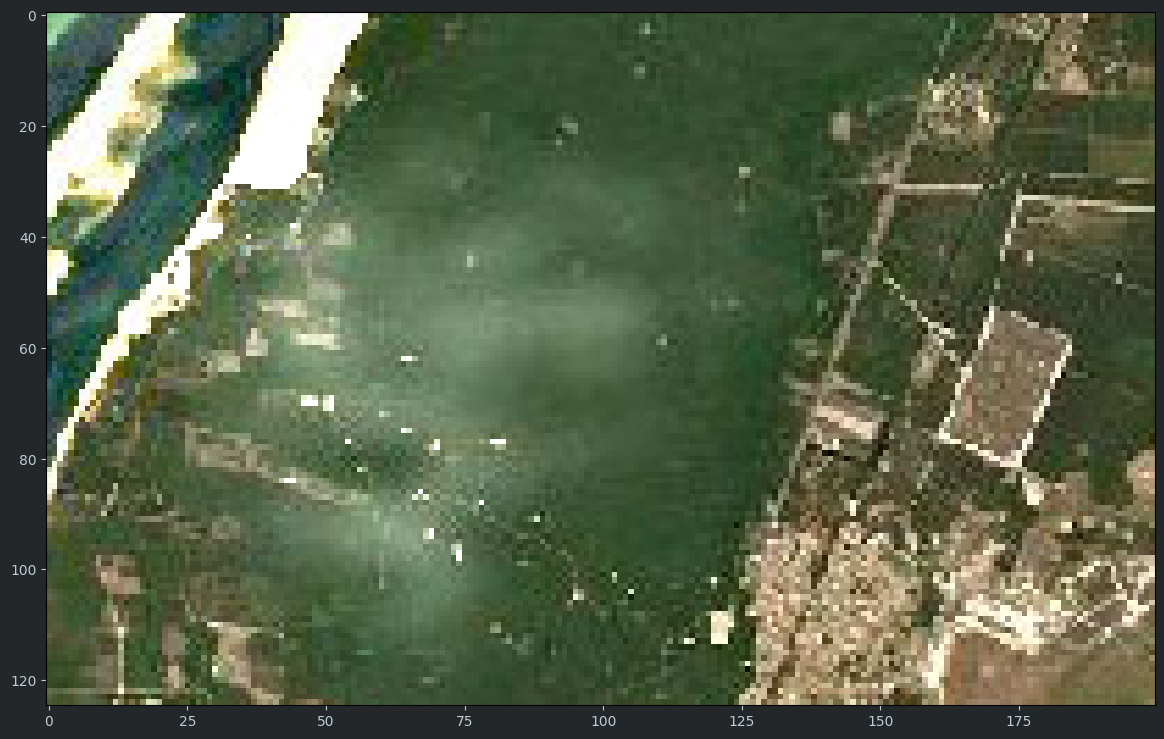

In [15]:
def generate_plume(img, position, brightness, width, direction, radius):
    plume = np.zeros_like(img)
    
    
    noise = PerlinNoise(octaves=10)
    xpix, ypix = img.shape[:2]
    smoke = scale_values(np.array([[noise([i/xpix, j/ypix]) for j in range(ypix)] for i in range(xpix)]))
    
    
    cone_mask = create_cone_mask(img.shape[:2], position, width, direction)
    circle_mask = create_circle_mask(img.shape[:2], position, radius)
    
    mask = cone_mask * circle_mask
    # mask = cv2.GaussianBlur(mask, (11,11), cv2.BORDER_DEFAULT)
    blr_size = int(radius * 0.3)
    mask = cv2.blur(mask, (blr_size,blr_size))
    
    plume = expand_to_rgb(smoke * mask) * brightness
    
    return plume

plume = generate_plume(img, (40, 125), 0.4, np.deg2rad(60), np.deg2rad(250), 100)
plt.imshow(clip(img + plume))

0.0 1.0


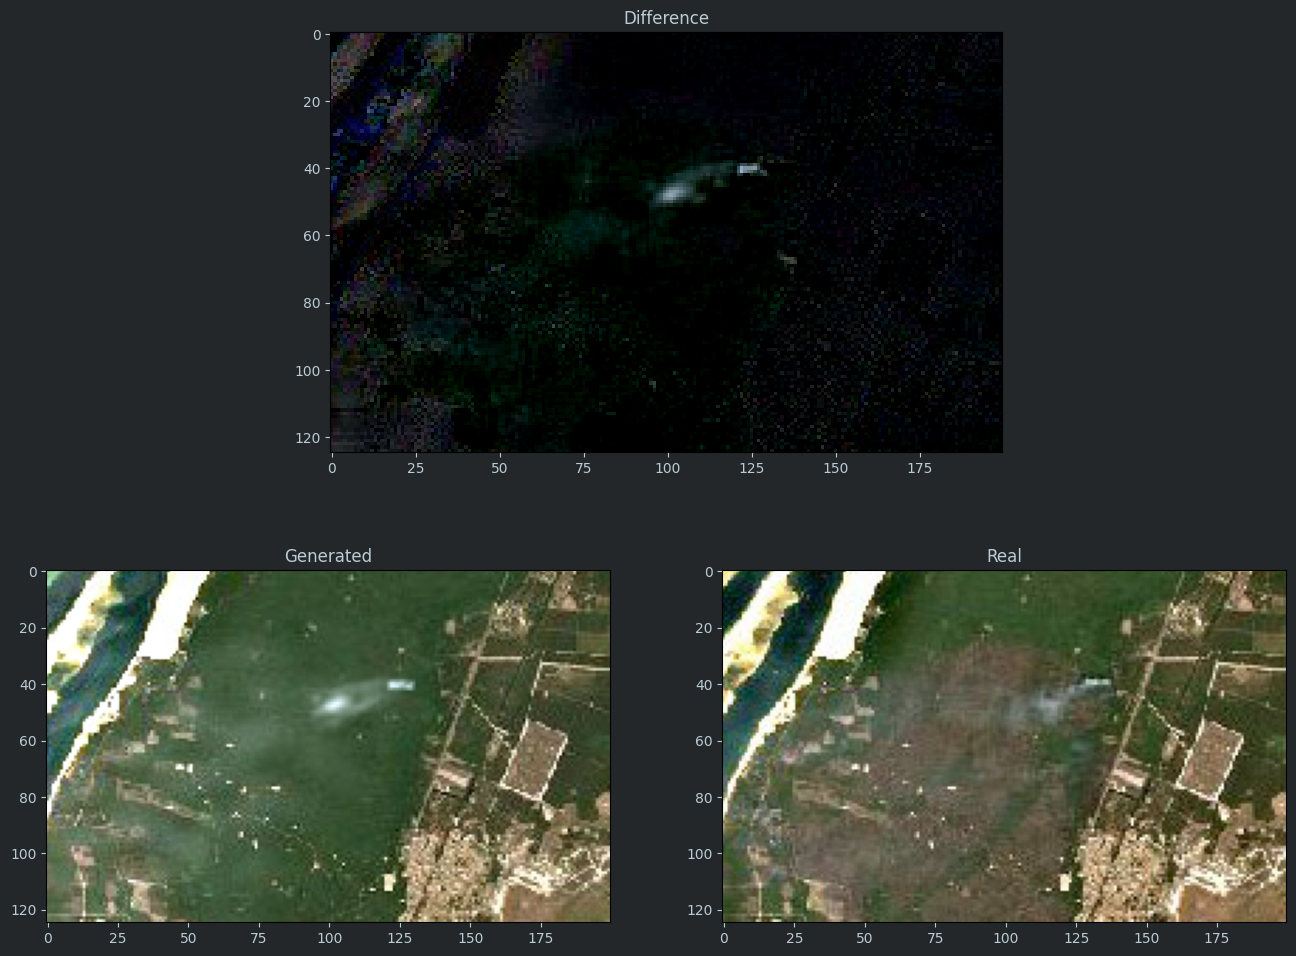

In [32]:
def generate_fire(img, position, direction, blue=1.2): # TODO: add wind speed which translates to width for trail and plume
    source = generate_source(img, position, 0.8, 4, 1/4)
    trail = generate_trail(img, position, 1, np.deg2rad(15), direction, 30)
    plume = generate_plume(img, position, 0.2, np.deg2rad(60), direction, 150)
    fire = source + trail + plume
    fire[:, : ,2] *= blue # boost blue channel
    return clip(img + fire)

img_with_fire = generate_fire(img, (40, 125), np.deg2rad(250))
print(img_with_fire.min(), img_with_fire.max())
plot_trio(img_with_fire, crop[1], clip(img_with_fire - crop[1]), labels=('Generated', 'Real', 'Difference'))

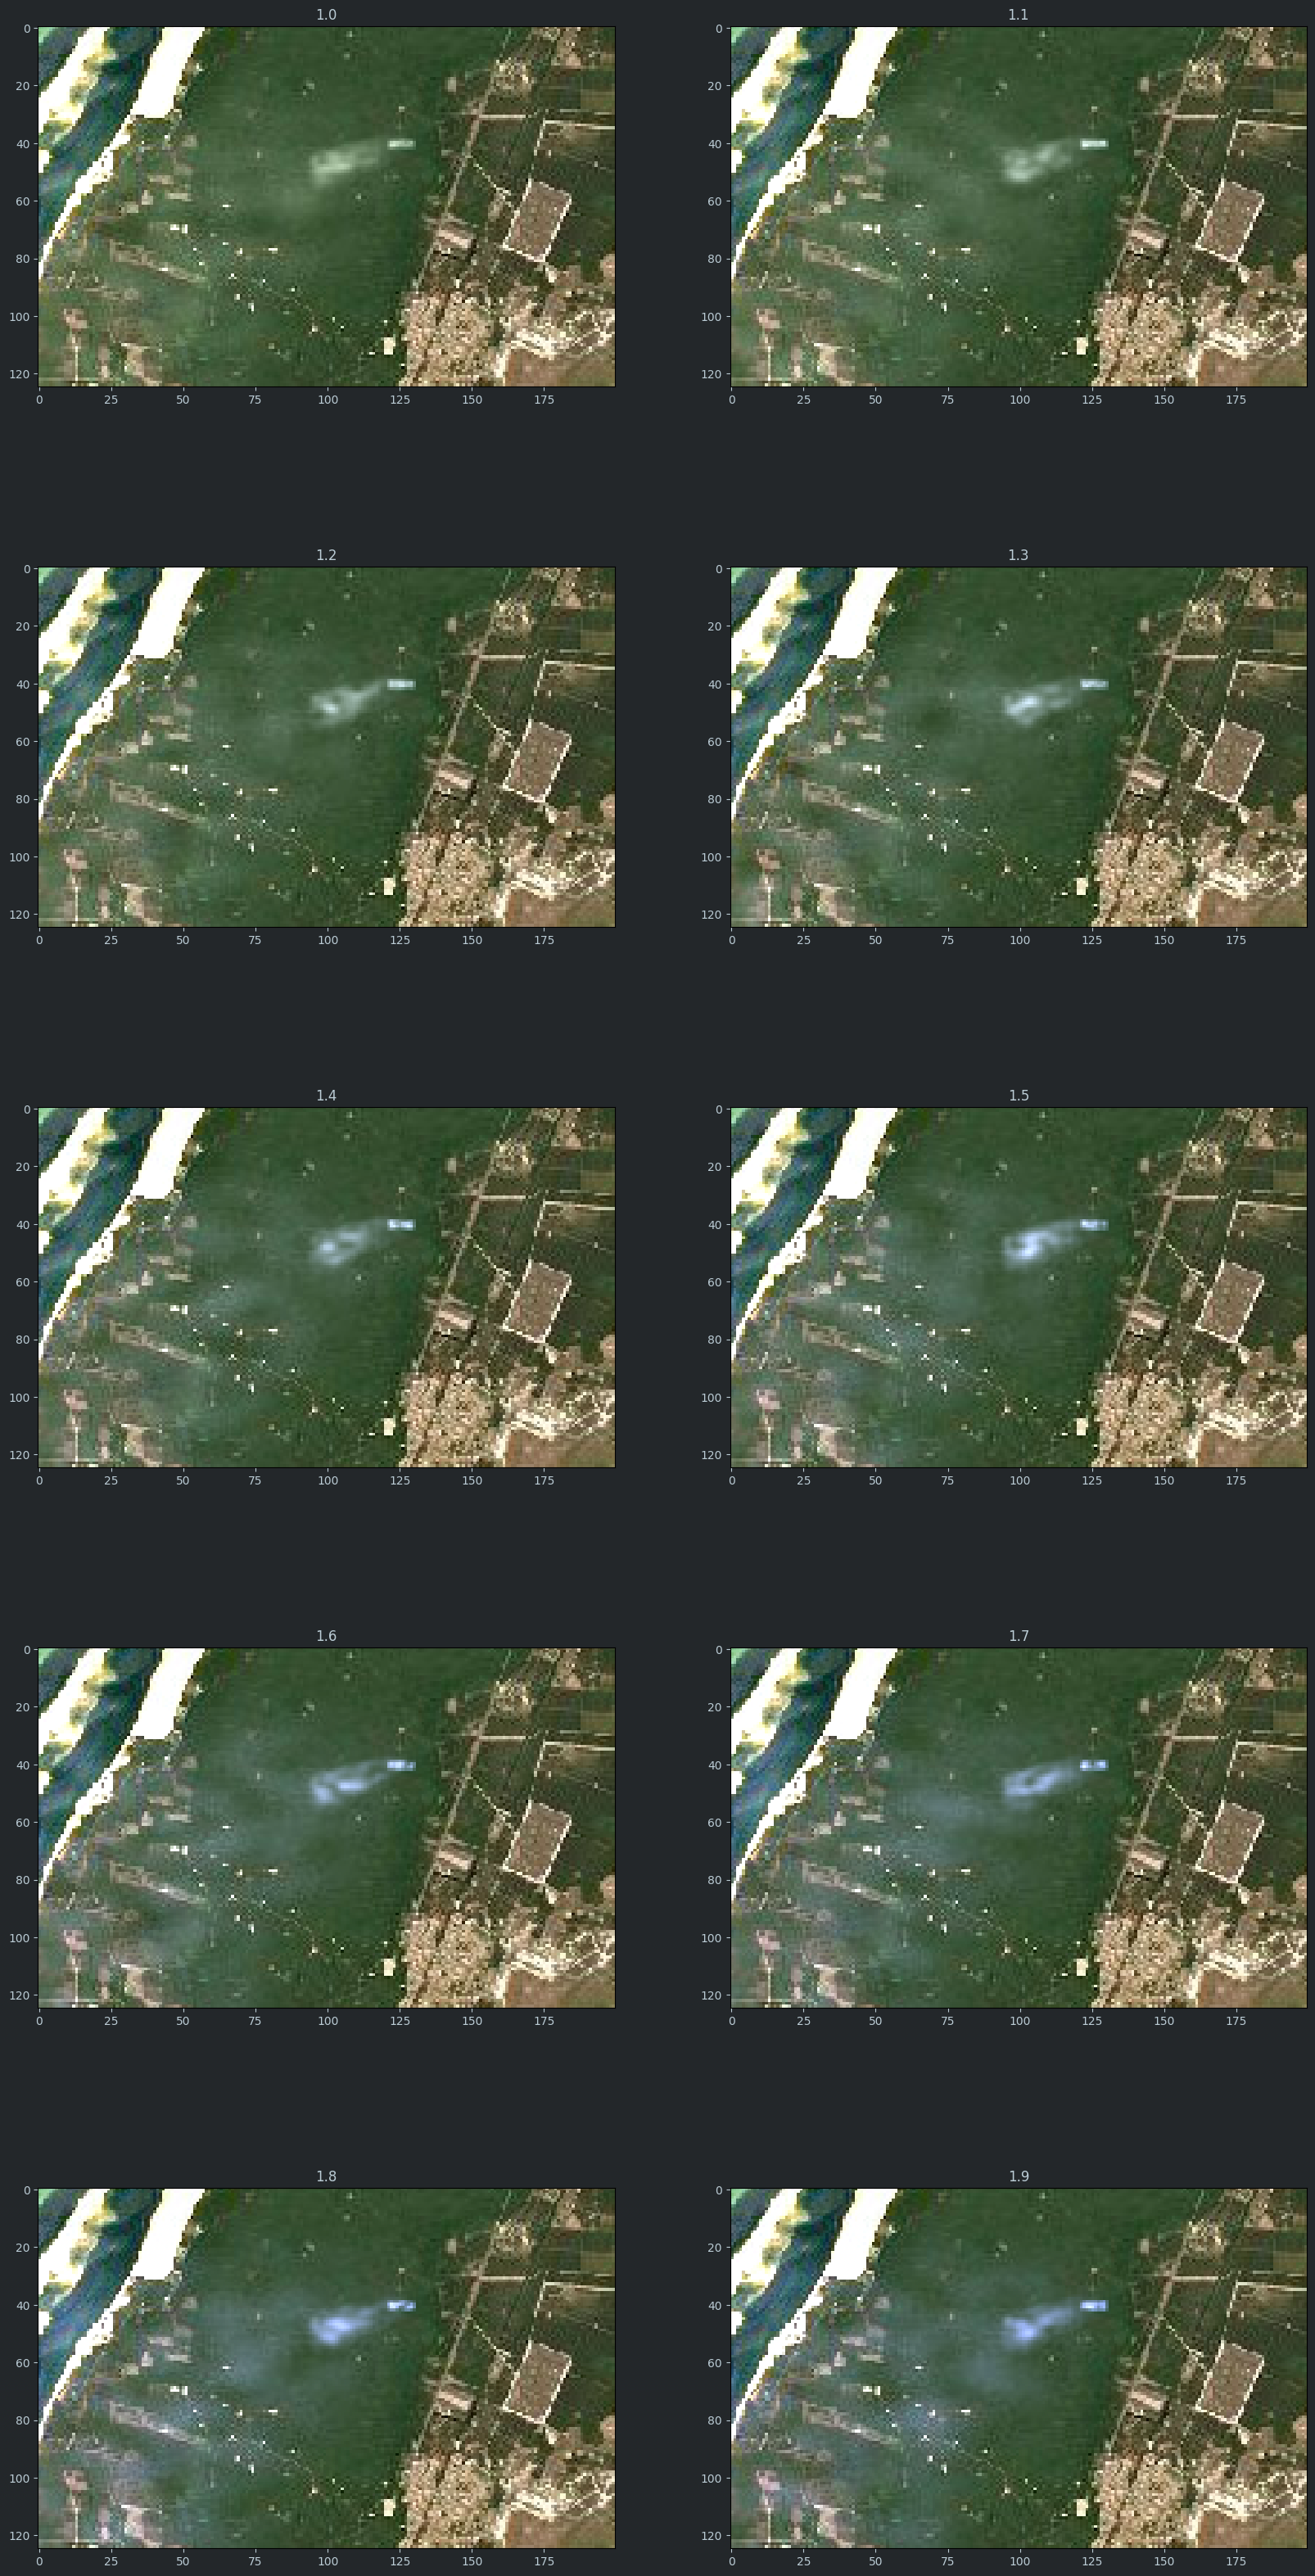

In [39]:

    
fig = plt.figure(figsize=(20, 50))

for i in range(10):
    ax = fig.add_subplot(6, 2, i + 1, title=f'{1 + i / 10}')
    ax.imshow(generate_fire(img, (40, 125), np.deg2rad(250), blue=1 + i / 10))